
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

...download...

In [205]:
import urllib.request
import zipfile
import os
import pandas as pd
import geopandas as gp
import statsmodels.formula.api as smf
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
urllib.request.urlretrieve("https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD",\
                           "Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
!mv Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv $PUIDATA

In [8]:
urllib.request.urlretrieve("https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip",\
                           "MNMapPLUTO.zip")
zip_ref = zipfile.ZipFile("MNMapPLUTO.zip", 'r')
zip_ref.extractall(os.getenv("PUIDATA"))
zip_ref.close()

In [11]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

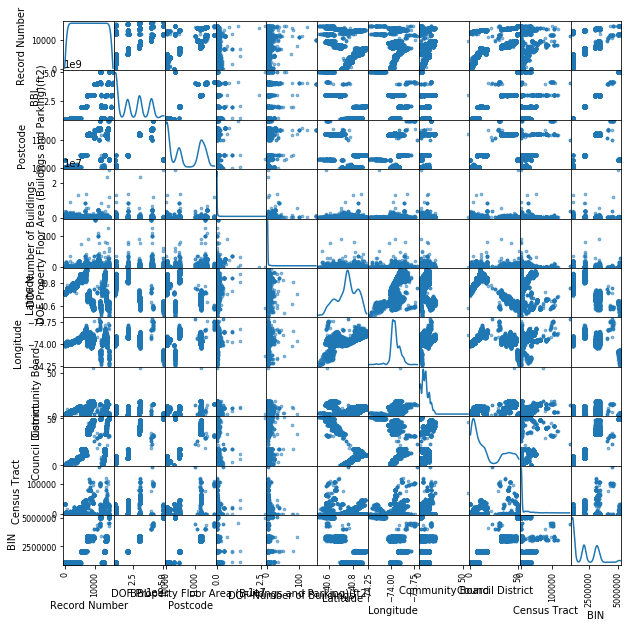

In [15]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

Figure 1: This graph shows the correlation of all the variables compared to each other. There appears to be patterns between certain variables but since there are too many variables it is hard to read the label. We then drop the columns to retain only variables that will be used.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [16]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [9]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [17]:
nrg = nrg[['BBL','Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)']]

In [19]:
bsize = bsize[['UnitsRes','UnitsTotal','YearBuilt','BBL','geometry']]

In [18]:
#leave
nrg.head()

BBL Site EUI(kBtu/ft2)  \
0  1.000410e+09                NaN   
1  4.021460e+09                NaN   
2  2.027620e+09                NaN   
3  1.006700e+09                NaN   
4  2.048300e+09                NaN   

  Reported Property Floor Area (Building(s)) (ft²)  
0                                           918919  
1                                              NaN  
2                                            64200  
3                                              NaN  
4                                            50000

In [21]:
#leave
bsize.head()

UnitsRes  UnitsTotal  YearBuilt           BBL  \
0        16          18       1920  1.015450e+09   
1        50          50       1914  1.007238e+09   
2        10          10       1910  1.016800e+09   
3        29          32       1928  1.013850e+09   
4        26          26       1900  1.011970e+09   

                                            geometry  
0  POLYGON ((997277.2344360352 221816.0936279297,...  
1  POLYGON ((984164.5626220703 211846.0704345703,...  
2  POLYGON ((1000742.195800781 227910.6640014648,...  
3  POLYGON ((994007.6885986328 219880.4284057617,...  
4  POLYGON ((992273.6849975586 224863.4904174805,...

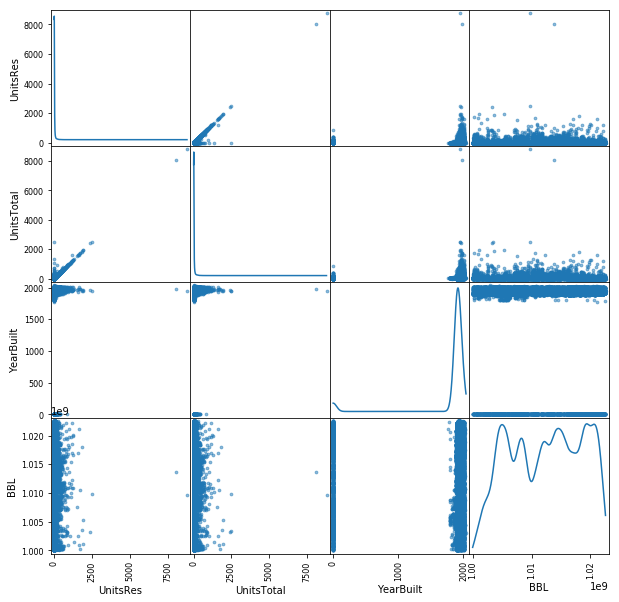

In [22]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

Figure 2: We plot the scatter matrix for the reduced dataset. A clear positive slope is visible between UnitsRes and UnitsTotal. The relationships between the other variables appear insignificant.

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [27]:
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'],errors='coerce')
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'],errors='coerce')
bsize['UnitsRes'] = pd.to_numeric(bsize['UnitsRes'],errors='coerce')
bsize['UnitsTotal'] = pd.to_numeric(bsize['UnitsTotal'],errors='coerce')
bsize['BBL'] = pd.to_numeric(bsize['BBL'],errors='coerce')

In [33]:
bsize['BBL'].astype(float)[:10], bsize.BBL.astype(float)[:10]

(0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [34]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [35]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [36]:
nrg.head()

BBL  Site EUI(kBtu/ft2)  \
0  1.000410e+09                 NaN   
1  4.021460e+09                 NaN   
2  2.027620e+09                 NaN   
3  1.006700e+09                 NaN   
4  2.048300e+09                 NaN   

   Reported Property Floor Area (Building(s)) (ft²)  
0                                          918919.0  
1                                               NaN  
2                                           64200.0  
3                                               NaN  
4                                           50000.0

In [39]:
bblnrgdataGPD = bsize.merge(nrg,left_on='BBL',right_on='BBL')
bblnrgdata = pd.merge(nrg,bsize,left_on='BBL',right_on='BBL')

In [40]:
bblnrgdata.head()

BBL  Site EUI(kBtu/ft2)  \
0  1.006700e+09                 NaN   
1  1.004370e+09                 NaN   
2  1.013110e+09               125.4   
3  1.009220e+09                 NaN   
4  1.007400e+09                 NaN   

   Reported Property Floor Area (Building(s)) (ft²)  UnitsRes  UnitsTotal  \
0                                               NaN         0           1   
1                                               NaN         0           4   
2                                          330000.0         0          56   
3                                               NaN       148         148   
4                                           68329.0         0           1   

   YearBuilt                                           geometry  
0       1987  POLYGON ((982544.9470214844 212642.966796875, ...  
1       1920  POLYGON ((988632.9398193359 204610.9329833984,...  
2       1977  POLYGON ((993141.1744384766 216172.3948364258,...  
3       1963  POLYGON ((989369.5852050781 206338.7576293945,...  
4       1920  POLYGON ((983418.6008300781 209632.8702392578,...

# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [83]:
bblnrgdataGPD['logunits'] = np.log(bblnrgdataGPD['UnitsRes']+1)
bblnrgdataGPD['logarea'] = np.log(bblnrgdataGPD['Site EUI(kBtu/ft2)']+1)
bblnrgdataGPD.head()

UnitsRes  UnitsTotal  YearBuilt           BBL  \
0        50          50       1914  1.007238e+09   
1        29          32       1928  1.013850e+09   
2        72          72       1923  1.021740e+09   
3       107         108       1931  1.008830e+09   
4       134         138       1910  1.008570e+09   

                                            geometry  Site EUI(kBtu/ft2)  \
0  POLYGON ((984164.5626220703 211846.0704345703,...                68.7   
1  POLYGON ((994007.6885986328 219880.4284057617,...                87.4   
2  POLYGON ((1004080.155029297 252930.9956054688,...               140.4   
3  POLYGON ((989337.639831543 209686.7838134766, ...                96.5   
4  POLYGON ((988035.3540039062 210290.9854125977,...                36.4   

   Reported Property Floor Area (Building(s)) (ft²)    lognrg   logarea  \
0                                           95844.0  3.931826  4.244200   
1                                          206989.0  3.401197  4.481872   
2                                           52920.0  4.290459  4.951593   
3                                           98359.0  4.682131  4.579852   
4                                          154000.0  4.905275  3.621671   

   logunits  
0  3.931826  
1  3.401197  
2  4.290459  
3  4.682131  
4  4.905275

(975192.59700622561, 1011685.747781372, 184893.11647644045, 263087.99234924314)

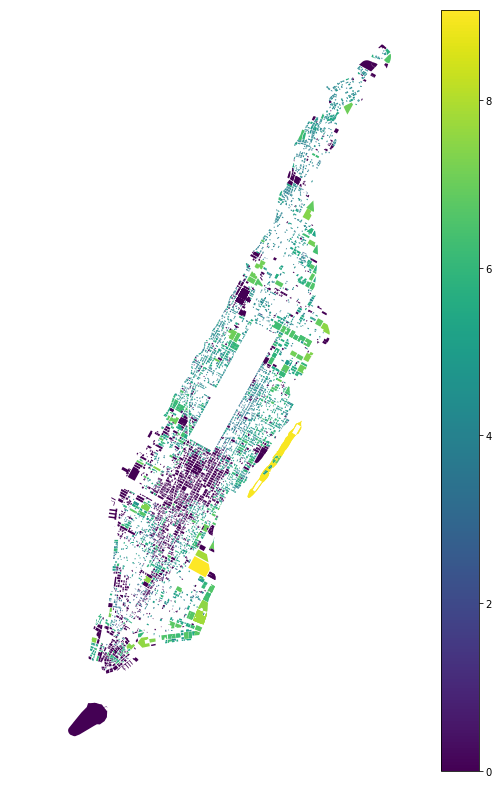

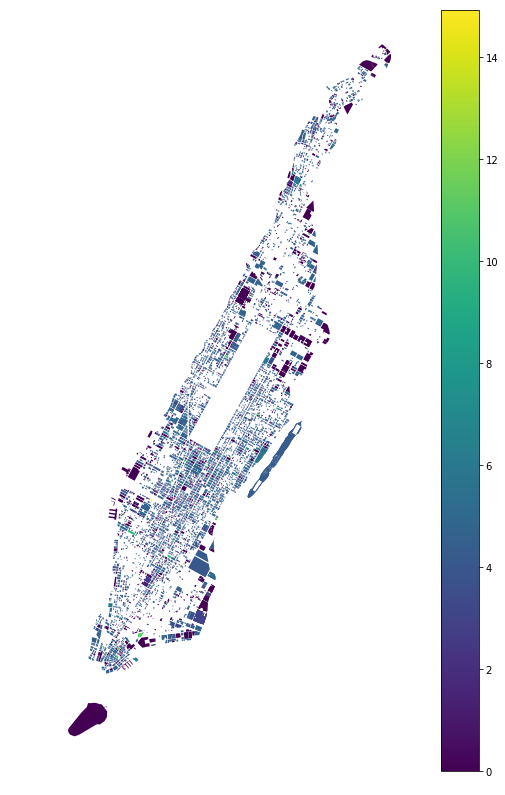

In [84]:
base = bblnrgdataGPD.plot(figsize=(12,14),cmap='viridis',column='logunits',k=5,legend=True)
base.axis('off')
base1 = bblnrgdataGPD.plot(figsize=(12,14),cmap='viridis',column='logarea',k=5,legend=True)
base1.axis('off')

Figure 3: We plot the energy consumed per square foot and the number of units. We notice the energy consumed is particularly high in the lower east Manhattan and Roosevelt Island. The number of units per neighborhood is quite even other than a few neighborhoods in lower Manhattan that have a high number of units.

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [101]:
bblnrgdata.rename(columns={'Reported Property Floor Area (Building(s)) (ft²)':'Reported Property Floor Area'},inplace=True)
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

Text(0,0.5,'Number of units')

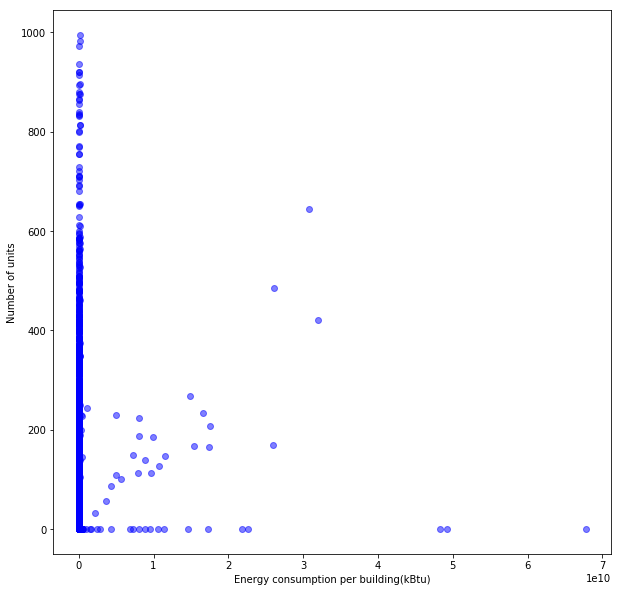

In [114]:
bblnrgdata_filtered = bblnrgdata[bblnrgdata.nrg<(pow(10,11))]
bblnrgdata_filtered = bblnrgdata_filtered[bblnrgdata_filtered.UnitsTotal<1000]
plt.figure(figsize=(10,10))
plt.plot(bblnrgdata_filtered.nrg,bblnrgdata_filtered.UnitsRes,'bo',alpha=0.5)
plt.xlabel('Energy consumption per building(kBtu)')
plt.ylabel('Number of units')

I filtered the data to values below $10^{11}$kBtu and buildings with 1000 units. Apart from the zero values(number of units or the energy consumption per building being zero) there appears the be correlation between the number of units and the energy consumption per building where increase in number of units means more energy consumed by the building.

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





Text(0,0.5,'$log_{10}$(x)')

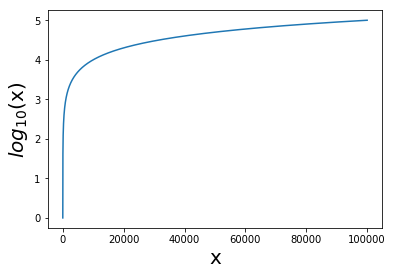

In [116]:
plt.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
plt.xlabel("x", fontsize=20)
plt.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


In [122]:
bblnrgdata = bblnrgdata[bblnrgdata.nrg>=1000]
bblnrgdata = bblnrgdata[bblnrgdata.UnitsTotal>=1]
bblnrgdata = bblnrgdata[bblnrgdata.nrg<=pow(10,9)]
bblnrgdata = bblnrgdata[bblnrgdata.UnitsTotal<=1000]
bblnrgdata.head()

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  UnitsRes  \
2   1.013110e+09               125.4                      330000.0         0   
10  1.010140e+09               154.9                      841709.0         0   
15  1.007660e+09               122.3                       59468.0         0   
16  1.008150e+09               117.0                      364000.0         0   
18  1.005050e+09                82.1                      235370.0         0   

    UnitsTotal  YearBuilt                                           geometry  \
2           56       1977  POLYGON ((993141.1744384766 216172.3948364258,...   
10           2       1999  POLYGON ((987726.6307983398 214846.9885864258,...   
15           8       1912  POLYGON ((984350.5375976562 209226.3930053711,...   
16          64       1954  POLYGON ((988118.5700073242 213939.774597168, ...   
18          24       1926  POLYGON ((982849.6038208008 203886.2427978516,...   

            nrg  
2    41382000.0  
10  130380724.1  
15    7272936.4  
16   42588000.0  
18   19323877.0

Text(0,0.5,'Log Energy per building(kBtu)')

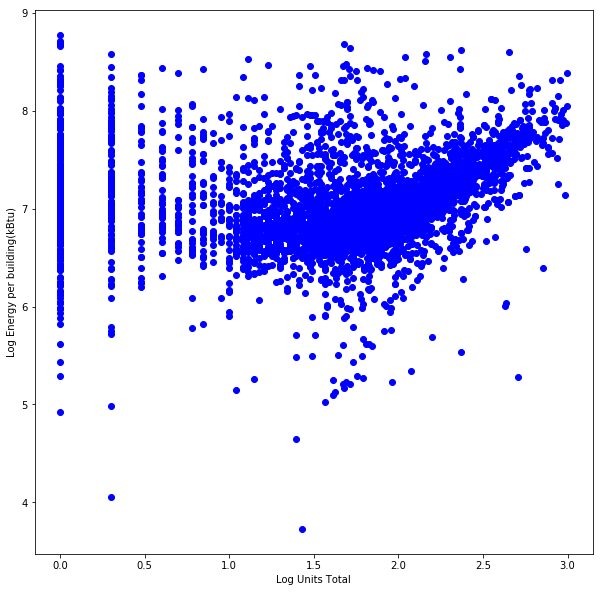

In [126]:
plt.figure(figsize=(10,10))
plt.plot(np.log10(bblnrgdata.UnitsTotal),np.log10(bblnrgdata.nrg),'bo')
plt.xlabel("Log Units Total")
plt.ylabel("Log Energy per building(kBtu)")

The plot of the log values shows the relationship between the variables clearly. The general trend seems to to be that an increase in units in the building means there is a likely increase in the energy per building.

Text(0,0.5,'Log Units Total')

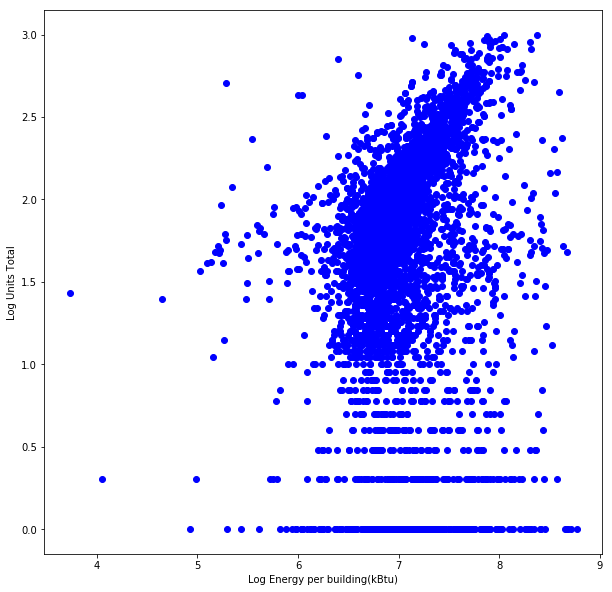

In [127]:
plt.figure(figsize=(10,10))
plt.plot(np.log10(bblnrgdata.nrg),np.log10(bblnrgdata.UnitsTotal),'bo')
plt.xlabel("Log Energy per building(kBtu)")
plt.ylabel("Log Units Total")

This plot shows the relationship between Log Units Total and Log Energy per building. This highlights the trend that an increase in the energy per building results in an increase in units in the building.

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

In [128]:
bblnrgdata.head()

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  UnitsRes  \
2   1.013110e+09               125.4                      330000.0         0   
10  1.010140e+09               154.9                      841709.0         0   
15  1.007660e+09               122.3                       59468.0         0   
16  1.008150e+09               117.0                      364000.0         0   
18  1.005050e+09                82.1                      235370.0         0   

    UnitsTotal  YearBuilt                                           geometry  \
2           56       1977  POLYGON ((993141.1744384766 216172.3948364258,...   
10           2       1999  POLYGON ((987726.6307983398 214846.9885864258,...   
15           8       1912  POLYGON ((984350.5375976562 209226.3930053711,...   
16          64       1954  POLYGON ((988118.5700073242 213939.774597168, ...   
18          24       1926  POLYGON ((982849.6038208008 203886.2427978516,...   

            nrg  
2    41382000.0  
10  130380724.1  
15    7272936.4  
16   42588000.0  
18   19323877.0

In [141]:
bblnrgdata['lognrg'] = np.log10(bblnrgdata['nrg'])
bblnrgdata['logunits'] = np.log10(bblnrgdata['UnitsTotal'])

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer**

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

In [142]:
OLS1 = smf.ols(formula='lognrg ~ logunits',data=bblnrgdata).fit()
OLS1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     126.0
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           7.03e-29
Time:                        23:48:16   Log-Likelihood:                -2872.8
No. Observations:                4904   AIC:                             5750.
Df Residuals:                    4902   BIC:                             5763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.8490      0.017    403.073      0.000         6.816     6.882
logunits       0.1059      0.009     11.223      0.000         0.087     0.124
==============================================================================
Omnibus:                      441.144   Durbin-Watson:                   1.544
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2438.126
Skew:                           0.238   Prob(JB):                         0.00
Kurtosis:                       6.421   Cond. No.                         6.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
OLS2 = smf.ols(formula='logunits~lognrg',data=bblnrgdata).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logunits   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     126.0
Date:                Mon, 26 Nov 2018   Prob (F-statistic):           7.03e-29
Time:                        23:48:19   Log-Likelihood:                -4845.8
No. Observations:                4904   AIC:                             9696.
Df Residuals:                    4902   BIC:                             9709.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0141      0.148      0.095      0.925        -0.277     0.305
lognrg         0.2367      0.021     11.223      0.000         0.195     0.278
==============================================================================
Omnibus:                      943.775   Durbin-Watson:                   1.538
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1604.775
Skew:                          -1.273   Prob(JB):                         0.00
Kurtosis:                       4.169   Cond. No.                         115.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared values are the same for both but the log likelihood is better in the case of logunits~lognrg. However, I feel that the number of floors affects the energy consumed by the building so I will use model 1(lognrg~logunits).

Text(0,0.5,'Log Energy per building(kBtu)')

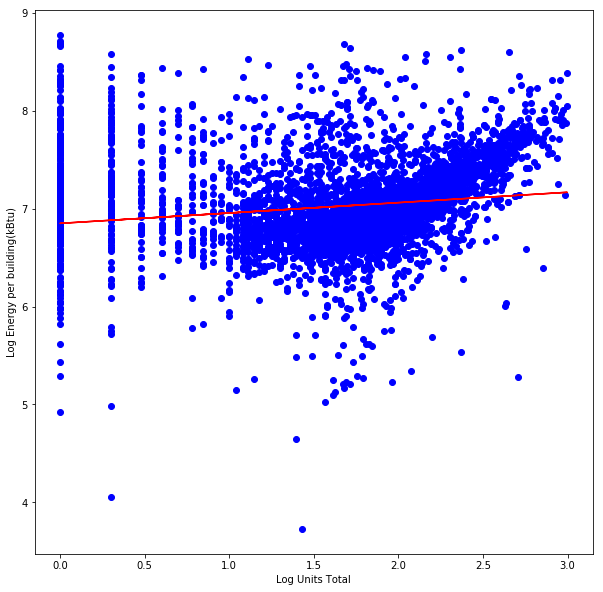

In [145]:
plt.figure(figsize=(10,10))
plt.plot(bblnrgdata.logunits,bblnrgdata.lognrg,'bo')
plt.plot(bblnrgdata.logunits,OLS1.predict(bblnrgdata),'r-')
plt.xlabel("Log Units Total")
plt.ylabel("Log Energy per building(kBtu)")

The plot of log energy per building vs log units total with a fitted linear model. We can see that there is a slight positive relation between the two. 

### Units vs Energy

### Energy against Units

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [174]:
bblnrgdata['logunits2'] = bblnrgdata.logunits**2

In [191]:
OLS3 = smf.ols(formula='lognrg ~ logunits2 + logunits',data=bblnrgdata).fit()
OLS3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     538.4
Date:                Tue, 27 Nov 2018   Prob (F-statistic):          4.22e-212
Time:                        10:57:30   Log-Likelihood:                -2448.0
No. Observations:                4904   AIC:                             4902.
Df Residuals:                    4901   BIC:                             4921.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.2239      0.020    363.744      0.000         7.185     7.263
logunits2      0.3049      0.010     30.448      0.000         0.285     0.325
logunits      -0.7078      0.028    -25.200      0.000        -0.763    -0.653
==============================================================================
Omnibus:                      581.021   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5960.885
Skew:                           0.067   Prob(JB):                         0.00
Kurtosis:                       8.399   Cond. No.                         25.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The r-squared values are much better for the polynomial model than the linear model.

In [222]:
bblnrgdata = bblnrgdata.sort_values('logunits',ascending=True)
bblnrgdata.head()

BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
1599  1.010230e+09               123.9                      262051.0   
734   1.007670e+09                10.3                      166544.0   
5290  1.007630e+09               112.7                       98750.0   
3502  1.017280e+09                83.7                       76680.0   
4126  1.021450e+09                 8.4                      113373.0   

      UnitsRes  UnitsTotal  YearBuilt  \
1599         0           1       1929   
734          0           1       1902   
5290         0           1       2006   
3502         0           1       1989   
4126         0           1       1930   

                                               geometry         nrg    lognrg  \
1599  POLYGON ((988656.432434082 217019.1431884766, ...  32468118.9  7.511457   
734   POLYGON ((984369.8569946289 209492.7396240234,...   1715403.2  6.234366   
5290  POLYGON ((986367.7536010742 214906.2564086914,...  11129125.0  7.046461   
3502  POLYGON ((1000496.621398926 234709.8829956055,...   6418116.0  6.807408   
4126  POLYGON ((1001547.852783203 247725.8973999023,...    952333.2  5.978789   

      logunits    lognrg2  logunits2  units2  
1599       0.0  15.022914        0.0       1  
734        0.0  12.468732        0.0       1  
5290       0.0  14.092922        0.0       1  
3502       0.0  13.614815        0.0       1  
4126       0.0  11.957578        0.0       1

Text(0,0.5,'Log Energy per building(kBtu)')

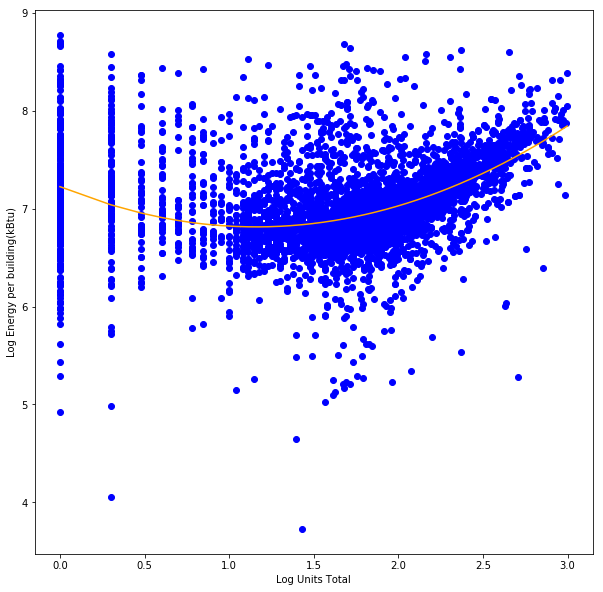

In [224]:
plt.figure(figsize=(10,10))
plt.plot(bblnrgdata.logunits,bblnrgdata.lognrg,'bo')
plt.plot(bblnrgdata.logunits, OLS3.predict(bblnrgdata),'-', color='orange')
plt.xlabel("Log Units Total")
plt.ylabel("Log Energy per building(kBtu)")

We see that a polynomial fit the data much better than the linear model.

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [321]:
#leave
def chi2(data, model,dof, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors == None:
        errors = np.ones(data.size)
    chisqr = 0
    for i in range(len(data)):
        chisqr = chisqr + ((data[i]-model[i])**2)/(errors[i]**2)
    return chisqr/dof
    

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [228]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities
bblnrgdata['errorsnrg'] = np.sqrt((1.0/bblnrgdata['Reported Property Floor Area'])+(1.0/bblnrgdata['Site EUI(kBtu/ft2)']))

# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
bblnrgdata['errorsunits'] = np.sqrt(1.0/bblnrgdata['UnitsTotal'])


## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


BBL  Site EUI(kBtu/ft2)  Reported Property Floor Area  \
3795  1.019900e+09                 0.1                       53440.0   

      UnitsRes  UnitsTotal  YearBuilt  \
3795        27          27       1909   

                                               geometry     nrg    lognrg  \
3795  POLYGON ((994066.3934326172 234073.4490356445,...  5344.0  3.727866   

      logunits   lognrg2  logunits2  units2  errorsnrg  errorsunits  
3795  1.431364  7.455733   2.048802     729   3.162281      0.19245

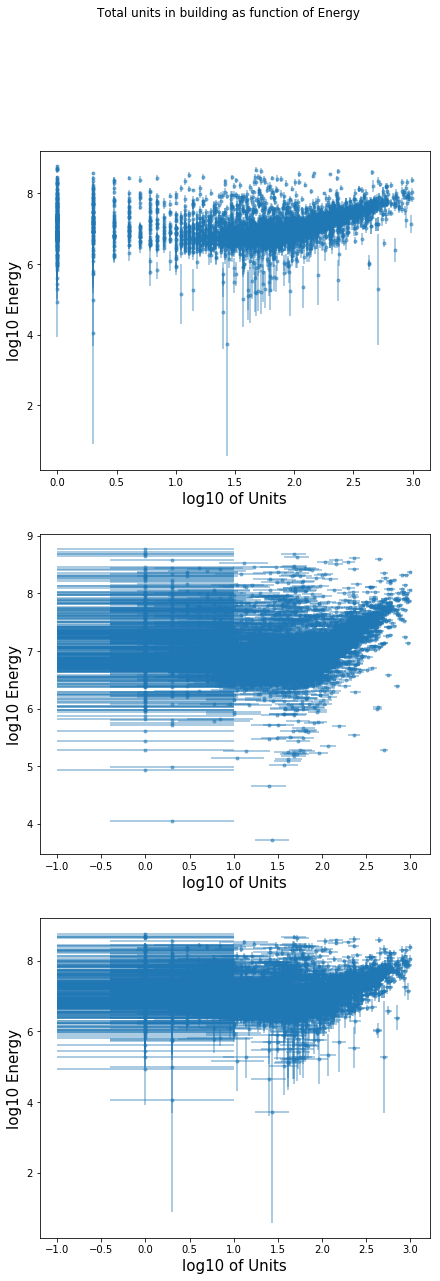

In [249]:
#I could also include errors for number of units
f, axarr = plt.subplots(3,figsize=(7,20))
f.suptitle('Sharing both axes')
axarr[0].errorbar( np.log10(bblnrgdata.UnitsTotal),np.log10(bblnrgdata.nrg), 
            yerr=bblnrgdata.errorsnrg, fmt='.',
            alpha=0.5)
axarr[0].set_xlabel("log10 of Units", fontsize=15)
axarr[0].set_ylabel("log10 Energy", fontsize=15)
plt.suptitle("Total units in building as function of Energy")
axarr[1].errorbar( np.log10(bblnrgdata.UnitsTotal),np.log10(bblnrgdata.nrg), 
            xerr=bblnrgdata.errorsunits, fmt='.',
            alpha=0.5)
axarr[1].set_xlabel("log10 of Units", fontsize=15)
axarr[1].set_ylabel("log10 Energy", fontsize=15)
axarr[2].errorbar( np.log10(bblnrgdata.UnitsTotal),np.log10(bblnrgdata.nrg), 
            xerr=bblnrgdata.errorsunits,yerr=bblnrgdata.errorsnrg, fmt='.',
            alpha=0.5)
axarr[2].set_xlabel("log10 of Units", fontsize=15)
axarr[2].set_ylabel("log10 Energy", fontsize=15)
print ("The largest error bar is for")
bblnrgdata[bblnrgdata.errorsnrg == bblnrgdata.errorsnrg.max()]

Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [378]:
dof = OLS1.df_resid
print ("degrees of freedom:" , dof)

degrees of freedom: 4902.0


In [379]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.array(np.log10(bblnrgdata.nrg)), np.array(OLS1.predict()),dof)))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.array(np.log10(bblnrgdata.nrg)), np.array(OLS1.predict()),dof, 
            np.array(bblnrgdata.errorsunits))))

print ("Energy vs Units chi square per DOF w independent variable error and dependent variable error: %.2f"%\
       (chi2(np.array(np.log10(bblnrgdata.nrg)), np.array(OLS1.predict()),dof, 
            np.array(np.sqrt(bblnrgdata.errorsnrg**2 + 
                             bblnrgdata.errorsunits**2) ))))

Energy vs Units residuals (no errors include): 0.20
Energy vs Units chi square per DOF w independent variable error only: 25.92
Energy vs Units chi square per DOF w independent variable error and dependent variable error: 6.28


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [380]:
dof = OLS3.df_resid
print ("degrees of freedom:" , dof)

degrees of freedom: 4901.0


In [381]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.array(np.log10(bblnrgdata.nrg)), np.array(OLS3.predict()),dof)))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.array(np.log10(bblnrgdata.nrg)), np.array(OLS3.predict()),dof, 
            np.array(bblnrgdata.errorsunits))))

print ("Energy vs Units chi square per DOF w independent variable error and dependent variable error: %.2f"%\
       (chi2(np.array(np.log10(bblnrgdata.nrg)), np.array(OLS3.predict()),dof, 
            np.array(np.sqrt(bblnrgdata.errorsnrg**2 + 
                             bblnrgdata.errorsunits**2) ))))

Energy vs Units residuals (no errors include): 0.21
Energy vs Units chi square per DOF w independent variable error only: 26.00
Energy vs Units chi square per DOF w independent variable error and dependent variable error: 6.59


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


We see that the adjusted chi-squared values are higher in the case of the curve. This means that the line has lower residuals. However, these values are marginally greater for the curve.

In [348]:
import statsmodels.graphics.regressionplots as smr

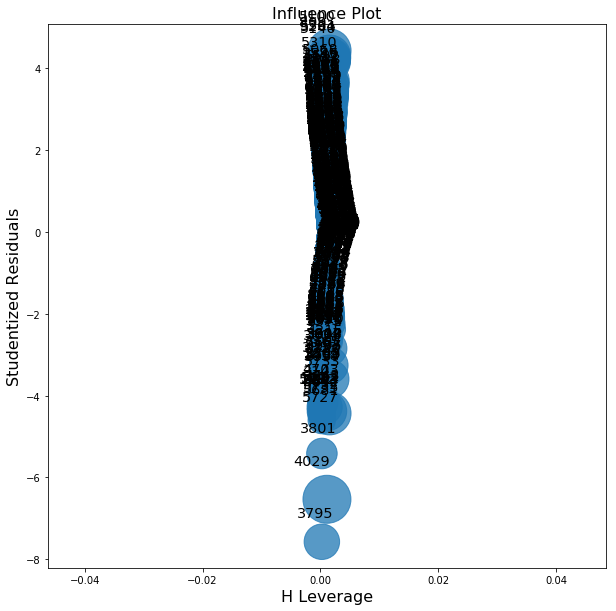

In [367]:
f, ax= plt.subplots(1,figsize=(10,10))
a = smr.influence_plot(OLS1,ax=ax)

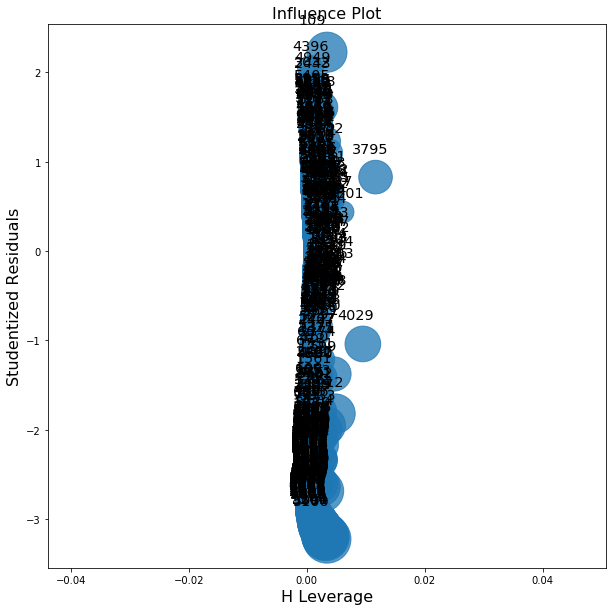

In [377]:
f, ax= plt.subplots(1,figsize=(10,10))
a = smr.influence_plot(OLS2,ax=ax)

We see that for the Energy vs Units plot the influence plot spreads over a larger y-axis range whereas for the Units vs Energy plot it spreads over a smaller range. A curve would better fit the second case as the endogenous variable varies more while a line would fit the first one better.

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

In [384]:
OLS3.compare_lr_test(OLS1,large_sample=True)

(780.07055916318143, 1.1618457763702641e-171, 1.0)

This high lr statistic tells us that the more complex model(the polynomial model) fits better than the linear model. The low p-value means we can reject the null hypothesis that the restricted model fits the data better.

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


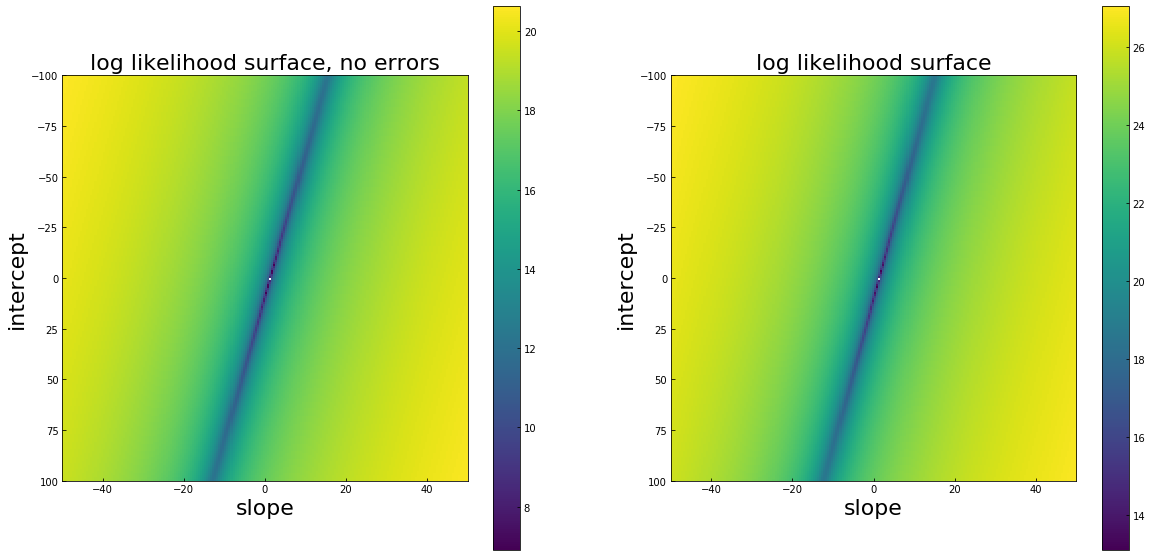

In [124]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


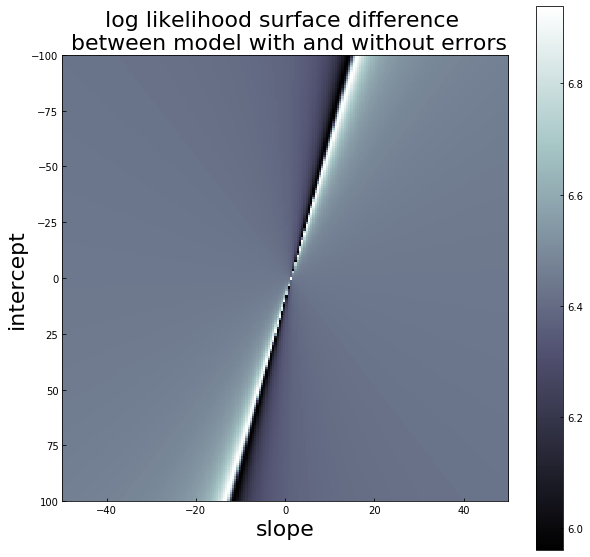

In [125]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: ...

# EXTRA CREDIT: a plot of anything related to these data

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


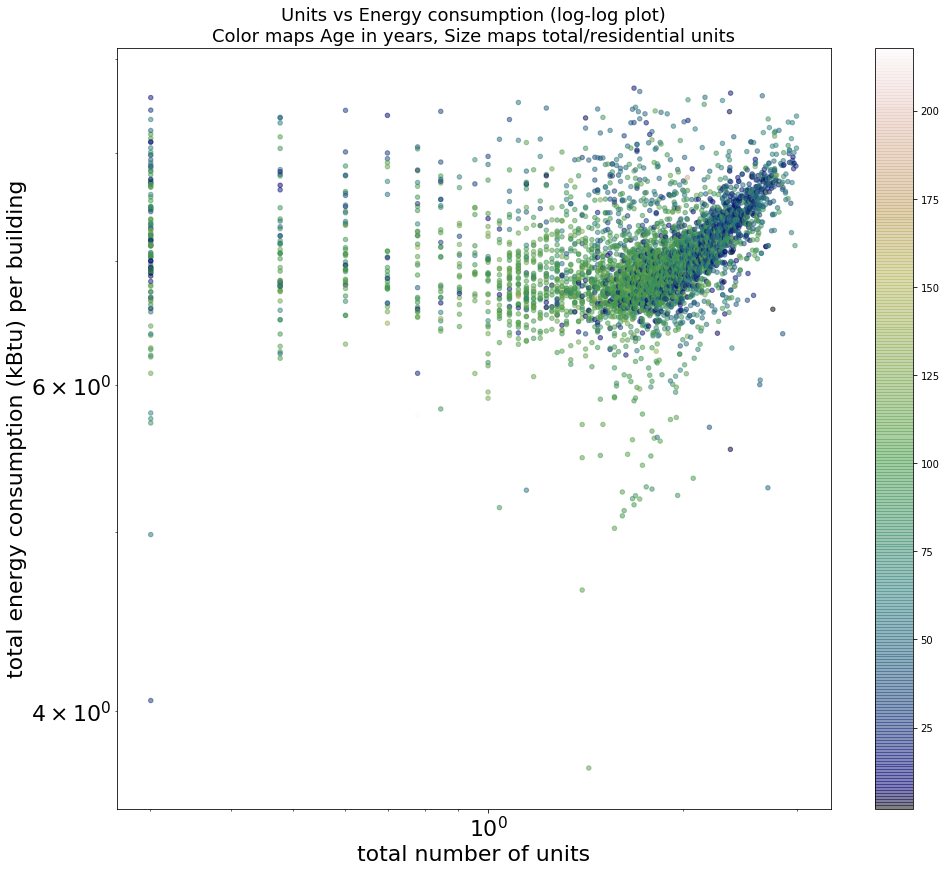

In [398]:
ax = plt.figure(figsize=(10,10)).add_subplot(111)
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter', x='logunits', y='lognrg', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                ax = ax,
                c= 2018 - bblnrgdata['YearBuilt'])
plt.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
plt.xlabel("total number of units", fontsize=22)
plt.ylabel("total energy consumption (kBtu) per building", fontsize=22);


Here we can see that more of the blue dots cluster towards the top right corner indicating that the older buildings had a large number of units and had greater energy consumption per building. 